In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 180
CHANNELS=3
EPOCHS=10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("Train", seed=123, shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 995 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 180, 180, 3)
[1 0 1 1 2 1 0 1 1 2 0 2 1 2 1 0 1 1 0 2 0 2 1 0 0 1 0 0 1 1 0 2]


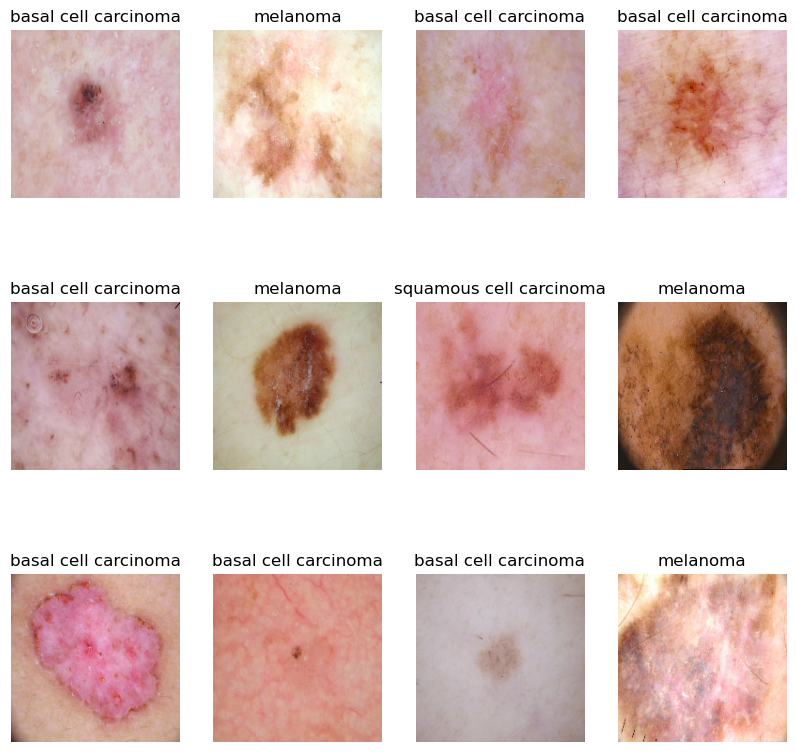

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

32

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 89, 89, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 43, 43, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 118336)             

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10


25/25 [==============================] - 22s 653ms/step - loss: 1.9107 - accuracy: 0.4650 - val_loss: 0.9635 - val_accuracy: 0.5833
Epoch 2/10
25/25 [==============================] - 17s 661ms/step - loss: 0.9950 - accuracy: 0.5275 - val_loss: 0.8713 - val_accuracy: 0.6562
Epoch 3/10
25/25 [==============================] - 15s 615ms/step - loss: 0.9484 - accuracy: 0.5500 - val_loss: 0.8573 - val_accuracy: 0.6771
Epoch 4/10
25/25 [==============================] - 15s 603ms/step - loss: 0.8737 - accuracy: 0.6062 - val_loss: 0.8084 - val_accuracy: 0.6458
Epoch 5/10
25/25 [==============================] - 15s 598ms/step - loss: 0.7486 - accuracy: 0.6787 - val_loss: 0.6562 - val_accuracy: 0.7292
Epoch 6/10
25/25 [==============================] - 15s 605ms/step - loss: 0.8141 - accuracy: 0.6637 - val_loss: 0.7744 - val_accuracy: 0.6979
Epoch 7/10
25/25 [==============================] - 15s 612ms/step - loss: 0.6555 - accuracy: 0.7125 - val_loss: 0.5805 - val_accuracy: 0.78

In [21]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 4s 157ms/step - loss: 0.5583 - accuracy: 0.7578


In [22]:
scores

[0.5582582950592041, 0.7578125]

In [23]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 25}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.9107084274291992,
 0.994950532913208,
 0.9484412670135498,
 0.8736856579780579,
 0.7486209273338318]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

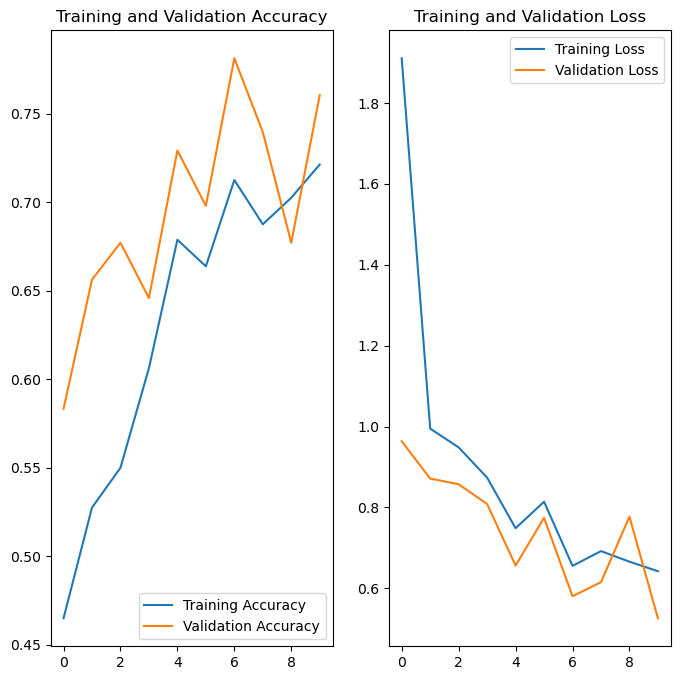

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: squamous cell carcinoma
1/1 [==============================] - 1s 571ms/step
predicted label: basal cell carcinoma


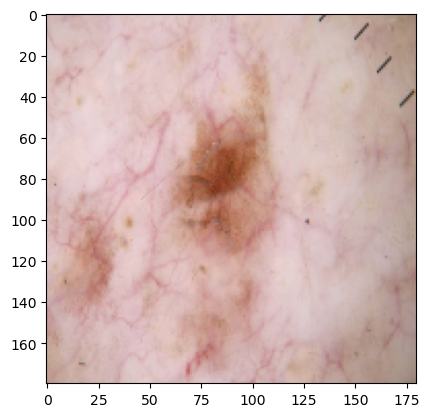

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


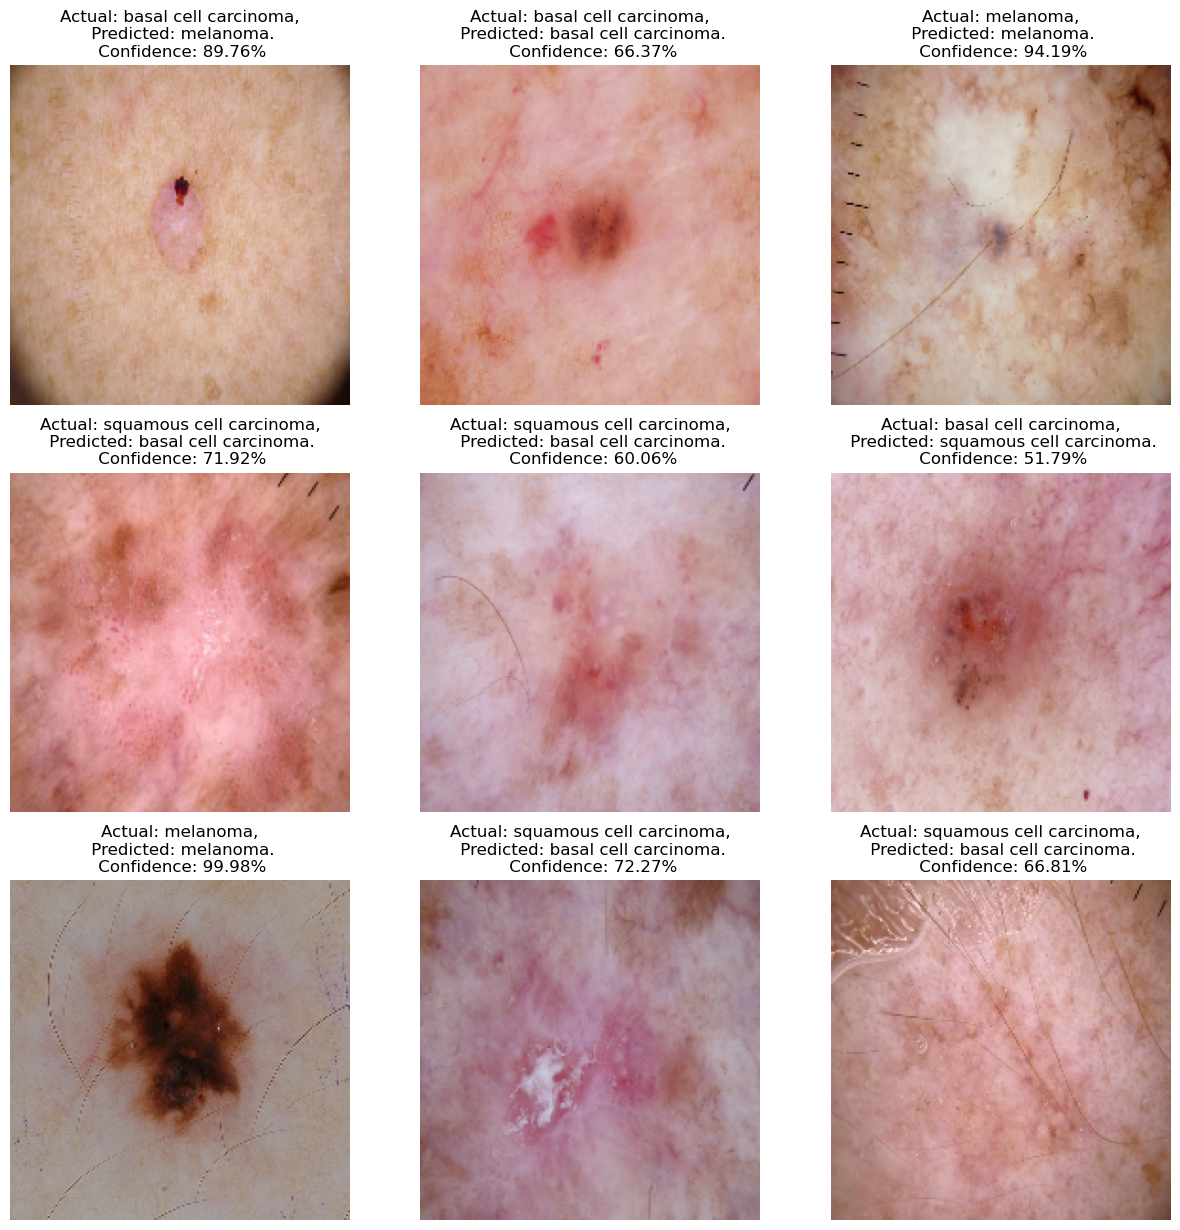

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
import os

# Ensure the directory exists
os.makedirs("../model", exist_ok=True)
model_version = max([int(i) for i in os.listdir("../model") + [0]]) + 1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets


In [38]:
model.save("../skincancermodel.h5")

C:\Users\its_y\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
